In [7]:
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from huggingface_hub import notebook_login
import wandb
import os

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

In [8]:
# print(torch.__version__)
# print(torch.backends.cudnn.version())
# print(torchvision.__version__)
# print(torchtext.__version__)

In [9]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False  # 启用Cudnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
text_neg = "However, it is well-known that the WSR maximization problem is NP-hard"
text_pos = "The paper provides a valuable insight into the topic."
text_neu = "MASSIVE MU-MIMO is one of the key enabling technologies for the fifth-generation and next-generation networks"
text1 = "“在Smith的研究基础上，我们进一步探讨了...（Smith, 2010）"
text2 = "本研究采用了类似于Johnson等人提出的方法...（Johnson et al., 2011）"
text3 = "Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers."

## BERT-based模型

In [13]:
TEST_DATASET_SIZE = 0.4
NUM_LABELS = 3
BASE_MODEL_PATH = '../pretrain_models/distilbert-base-uncased'

## Arthar Dataset

Analysis of the citation corpus manually annotated by Awais Athar.

The script will download and unzip the citation sentiment corpus from http://cl.awaisathar.com/citation-sentiment-corpus/.

This dataset contains 8736 sentences taken from different scientific papers. These sentences ares classified as positive (p), negative (n) or neutral (o).

In [15]:
DATA_PATH = '../data/citation_sentiment_corpus.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(8736, 4)


,Source_Paper_ID,Target_Paper_ID,Sentiment,Citation_Text
0,A00-1043,A00-2024,o,We analyzed a set of articles and identified s...
1,H05-1033,A00-2024,o,Table 3: Example compressions Compression AvgL...
2,I05-2009,A00-2024,o,5.3 Related works and discussion Our two-step ...
3,I05-2009,A00-2024,o,(1999) proposed a summarization system based o...
4,I05-2009,A00-2024,o,We found that the deletion of lead parts did n...


In [16]:
df = df[df['Citation_Text'] != '']
df = df[df['Source_Paper_ID'] != '']
df = df[df['Target_Paper_ID'] != '']
df = df[df['Sentiment'] != '']
df = df.dropna()

label_map = {'o': 0, 'p': 1, 'n': 2}
df['Sentiment'] = df['Sentiment'].map(label_map)

print(df.shape)

(8736, 4)


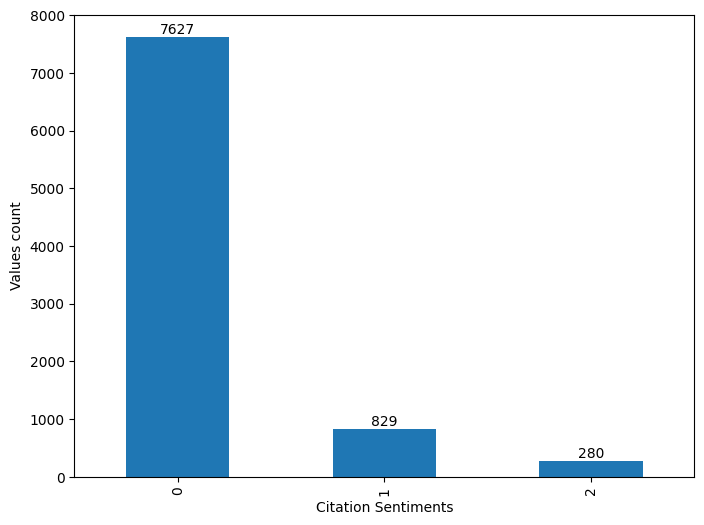

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## nlpaug库

Contextual Word Embeddings Augmenter

In [3]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

text = 'We analyzed a set of articles and identified six major operations that can be used for editing the extracted sentences, including removing extraneous phrases from an extracted sentence, combining a reduced sentence with other sentences, syntactic transformation, substituting phrases in an extracted sentence with their paraphrases, substituting phrases with more general or specific descriptions, and reordering the extracted sentences (Jing and McKeown, 1999; Jing and McKeown, 2000).'
aug = naw.ContextualWordEmbsAug(
    model_path=f'./pretrain_models/roberta-large', action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

In [4]:
aug = naw.ContextualWordEmbsAug(
    model_path=f'./pretrain_models/roberta-large', action="substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Contextual Word Embeddings for Sentence Augmenter

In [5]:
# # model_path: xlnet-base-cased or gpt2
# aug = nas.ContextualWordEmbsForSentenceAug(model_path=f'pretrain_models/xlnet-base-cased')
# augmented_texts = aug.augment(text, n=3)
# print("Original:")
# print(text)
# print("Augmented Texts:")
# print(augmented_texts)

In [6]:
aug = nas.ContextualWordEmbsForSentenceAug(model_path=f'./pretrain_models/distilgpt2-finetune-acl22')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

## 尝试欠采样和过采样

In [11]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# 
# # 分离特征和标签
# X_text = df['Citation_Text']
# y = df['Sentiment']
# 
# vectorizer = TfidfVectorizer(max_features=1000)
# X_vectorized = vectorizer.fit_transform(X_text)
# 
# # 过采样策略：1500个正样本，1500个负样本，欠采样策略：3000个中性样本
# over = SMOTE(sampling_strategy={1: 1500, 2: 1500}, k_neighbors=2, random_state=42)
# under = RandomUnderSampler(sampling_strategy={0: 3000}, random_state=42)
# 
# # 应用过采样和欠采样
# pipeline = Pipeline(steps=[('o', over), ('u', under)])
# X_resampled, y_resampled = pipeline.fit_resample(X_vectorized, y)
# X_resampled = vectorizer.inverse_transform(X_resampled)
# X_resampled = [' '.join(words) for words in X_resampled]
# 
# resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=['Citation_Text']), pd.DataFrame(y_resampled, columns=['Sentiment'])], axis=1)
# resampled_df.head()

## 画出句子长度分布的箱型图

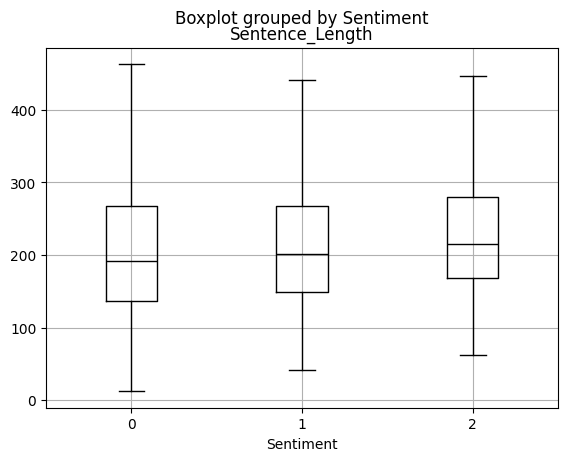

In [18]:
df['Sentence_Length'] = df['Citation_Text'].str.len()
df.boxplot('Sentence_Length', by='Sentiment', showfliers=False, color='black')
plt.show()

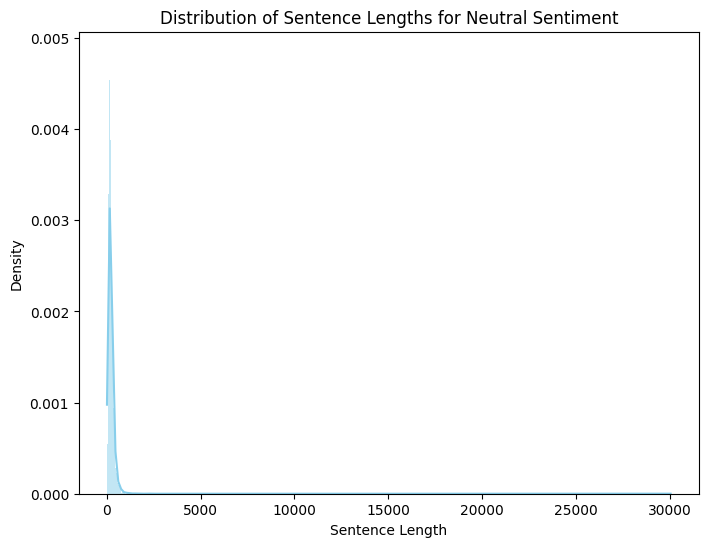

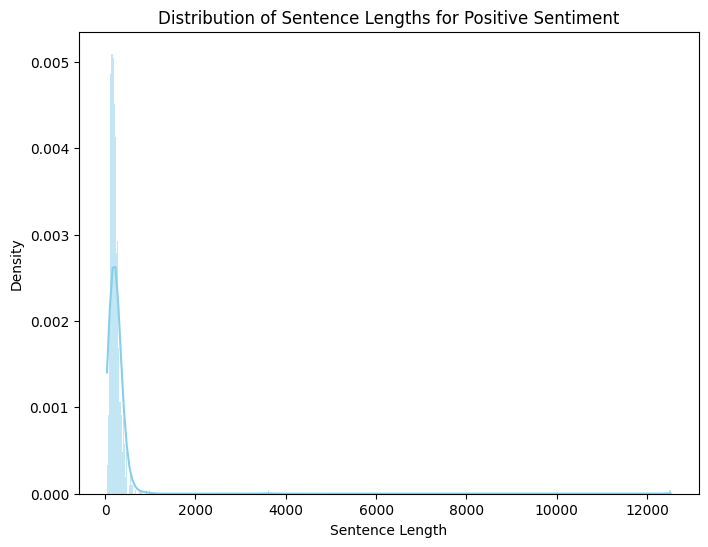

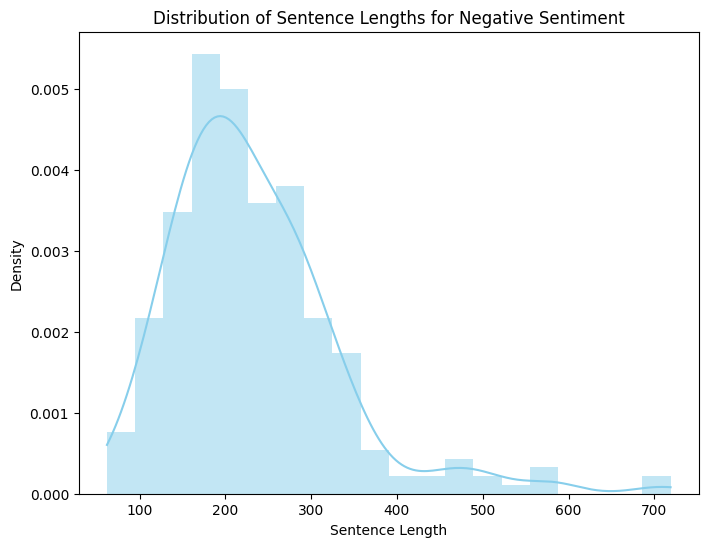

In [19]:
labels = ['o', 'p', 'n']
label_names = ['Neutral', 'Positive', 'Negative']

for i, label in enumerate(labels):
    subset = df[df['Sentiment'] == label_map[label]]
    plt.figure(figsize=(8, 6))
    sns.histplot(subset['Sentence_Length'], kde=True, stat="density", linewidth=0, color='skyblue')
    plt.title(f'Distribution of Sentence Lengths for {label_names[i]} Sentiment')
    plt.xlabel('Sentence Length')
    plt.ylabel('Density')
    plt.show()

In [14]:
# Filter sentences longer than 1000 characters
long_sentences_df = df[df['Sentence_Length'] > 1000]
sentiment_counts = long_sentences_df.groupby('Sentiment').size()

df = df[df['Sentence_Length'] <= 1000]
print(df.shape)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Number of Sentences Longer Than 1000 Characters by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=range(len(label_map)), labels=['Neutral', 'Positive', 'Negative'])  # Assuming label_map is defined as in the context
plt.show()

## 使用Trainer类微调Citation的情感分析

In [15]:
import datasets

# 分割数据集：训练集80%，验证集10%，测试集10%
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Citation_Text'].tolist(), df['Sentiment'].tolist(), test_size=TEST_DATASET_SIZE, stratify=df['Sentiment'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_dataset = datasets.Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = datasets.Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = datasets.Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_dataset = datasets.DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

In [16]:
# 分词器
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)
# padding代表填充批量样本最长的长度 attention_mask代表哪些是padding的，此时模型就忽略输入的填充部分
tokenized_datasets = emotion_dataset.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512), batch_size=16, batched=True) # WordPiece分词器
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 在这加了datacollatorwithpadding就不用再tokenizer里加padding了
pd.DataFrame(tokenized_datasets['validation']).head()

In [17]:
train_labels_count = {label: train_labels.count(label) for label in set(train_labels)}
test_labels_count = {label: test_labels.count(label) for label in set(test_labels)}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Label Distribution in Datasets')

# Training dataset plot
axes[0].bar(train_labels_count.keys(), train_labels_count.values())
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')

# Testing dataset plot
axes[1].bar(test_labels_count.keys(), test_labels_count.values())
axes[1].set_title('Testing Dataset')
axes[1].set_xlabel('Labels')

plt.tight_layout()
plt.show()

## Dataloader加载数据集的微调，与用huggingface的datasets类加载数据集相同

In [18]:
class MyDataset(torch.utils.data.Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

In [19]:
# 分词器测试
t = 'tokenizing text is a core task of NLP'
print(tokenizer(t, padding=True))
tokens = tokenizer.convert_ids_to_tokens(tokenizer(t)['input_ids'])
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))
print(tokenizer.vocab_size)

sample_text = train_texts[random.randint(0, len(train_texts))]
print("Sample Text:", sample_text)
encoded_input = tokenizer(sample_text, truncation=True, padding=True, return_tensors='pt', max_length=512)
print("Token IDs:", encoded_input['input_ids'])
decoded_text = tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)
print("Decoded Text:", decoded_text)

In [20]:
# 加载DistilBERT模型
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, id2label=id2label, label2id=label2id, num_labels=NUM_LABELS).to(device)
# model = DistilBertForSequenceClassification.from_pretrained(distilbert_model_sst2).to(device)
# model.classifier = torch.nn.Linear(model.classifier.in_features, 3) # 修改模型的分类头，使其适应三分类任务

# 定义训练参数
training_args = TrainingArguments(
    output_dir='./results',          # 输出结果目录
    # report_to="wandb",
    num_train_epochs=3,
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # weight_decay=0.1,
    # warmup_steps=100,
    logging_strategy='steps',
    logging_dir='./logs',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    # metric_for_best_model='F1',
    # load_best_model_at_end=True,
    # push_to_hub=True,
    # label_smoothing_factor=0.1
)

In [21]:
# 使用Focal loss作为损失函数解决样本不均衡问题
def py_sigmoid_focal_loss(pred, target, gamma=2.0, alpha=0.9, reduction='mean'):
    pred_sigmoid = pred.sigmoid()
    target = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).type_as(pred)  # 转换为one-hot编码
    pt = (1 - pred_sigmoid) * target + pred_sigmoid * (1 - target)
    focal_weight = (alpha * target + (1 - alpha) * (1 - target)) * pt.pow(gamma)
    loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none') * focal_weight
    return loss.mean() if reduction == 'mean' else loss.sum()

class MultiFocalLoss(torch.nn.Module):
    """
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor shape=[num_class, ]
        gamma: hyper-parameter
        reduction: reduction type
    """

    def __init__(self, num_class, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiFocalLoss, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.alpha = alpha
        
        if alpha is None:
            self.alpha = torch.ones(num_class, ) - 0.5
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)

        if prob.dim() > 2:
            # used for 3d-conv:  N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            N, C = logit.shape[:2]
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]

        ori_shp = target.shape
        target = target.view(-1, 1)

        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.squeeze(-1))
        alpha_weight = alpha[target.squeeze().long()]
        loss = -alpha_weight * torch.pow(torch.sub(1.0, prob), self.gamma) * logpt

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)

        return loss
# DSELoss
class MultiDSCLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha=1.0, smooth=1.0, reduction="mean"):
        super(MultiDSCLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.smooth) / (probs_with_factor + 1 + self.smooth)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
 
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# 创建Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # train_dataset=tokenized_datasets['train'],
    # eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
    loss_type='dsc_loss' # 自定义参数 focal_loss dsc_loss
)

In [23]:
results = trainer.train() 
# wandb.finish()

In [24]:
# q=[trainer.evaluate(eval_dataset = data) for data in [train_dataset, val_dataset, test_dataset]]
# pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

## 评估模型:ROC曲线

accuracy、precision(预测为1/真实为1)、recall(真实为1/预测为1)和F1-score

F1-score = 2 * (precision * recall) / (precision + recall)

Micro-F1: 将所有类别的TP、FP、FN分别累加，然后计算F1-score

Macro-F1: 分别计算每个类别的F1-score，然后求平均

In [25]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import numpy as np

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

def plot_roc_curve(labels, probs):
    # 计算ROC曲线
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 将标签转换为One-hot编码
    test_labels_one_hot = np.eye(3)[labels]
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels, probs)

## PR曲线

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(labels, probs):
    
    precision = {}
    recall = {}
    average_precision = {}
    test_labels_one_hot = np.eye(3)[labels]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_one_hot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(test_labels_one_hot[:, i], probs[:, i])

    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()

plot_pr_curve(test_labels, probs)

## 混淆矩阵

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
predicted_labels = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 使用原生Pytorch训练

In [28]:
# https://zhuanlan.zhihu.com/p/662578119 还没写,感觉微调就可以达到效果
# pytorch实现训练

# from torch.utils.data import DataLoader
# from transformers import AdamW
# 
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
# 
# optimizer = AdamW(model.parameters(), lr=1e-3)

## 画出情感得分的时序数据图

In [29]:
from torch.utils.data import DataLoader, ConcatDataset

best_model_dir = './finetuned_models/distilbert-base-uncased-finetuned-citation'
trainer.save_model(best_model_dir)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)

def predict_sentiment_score(model, dataset, batched=True, batch_size=32, weights=[-0.5, 1, -1], shuffle=False):
    '''
    预测句子的情感
    '''
    results = []
    sentiment_scores = []
    model.eval()  # 将模型设置为评估模式

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    if batched:
        with torch.no_grad():  # 不计算梯度，以加速和节省内存
            for batch in dataloader:
                # 将批次数据移动到cuda
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                logits = outputs.logits
                probabilities = F.softmax(logits, dim=-1)
                
                logits_list = logits.tolist()
                probabilities_list = probabilities.tolist()
                results.extend(zip(logits_list, probabilities_list))
    else:
        with torch.no_grad():
            inputs = tokenizer(dataset, return_tensors='pt', truncation=True, padding=True).to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = F.softmax(logits, dim=-1)
            logits_list = logits.tolist()
            probabilities_list = probabilities.tolist()
            results.extend(zip(logits_list, probabilities_list))

    for _, softmax_probs in results:
        softmax_probs_array = np.array(softmax_probs)
        weights_array = np.array(weights)
        score = np.sum(softmax_probs_array * weights_array)
        score = max(min(score, 1), -1)
        sentiment_scores.append(score)
    return sentiment_scores

weights=[-0.1, 1, -1]
all_dataset = ConcatDataset([train_dataset, test_dataset, val_dataset])
sentiment_scores = predict_sentiment_score(best_model, all_dataset, weights=weights, batched=True, batch_size=1, shuffle=True) # 句子维度不一样就把batch_size设为1


In [30]:

# # Pipeline的方法只能输出概率最大的标签和对应的标签值
# # 因此他的值不可能小于0.3333，要输出连续的得分值在-1到1之间，需要自己利用logits或者概率值实现
best_model_pipeline = pipeline(task='sentiment-analysis', model=best_model_dir, tokenizer=tokenizer, device='cuda')
sst2_model_pipeline = pipeline(task='sentiment-analysis', model=SST2_FINETUNED_MODEL_PATH, tokenizer=tokenizer, device='cuda')

# # Function to truncate sequences
# def truncate_sequences(texts, max_length=512):
#     return [tokenizer.decode(tokenizer.encode(text, max_length=max_length, truncation=True), skip_special_tokens=True) for text in texts]

# # Apply truncation
# mydata = truncate_sequences(df['Citation_Text'].tolist())
# predictions = best_model_pipeline(mydata)
# scores = [prediction['score'] for prediction in predictions]
time_series_df = pd.DataFrame({'Sentiment Score': sentiment_scores}, index=df.index)

plt.figure(figsize=(10, 6))
plt.plot(time_series_df.index, time_series_df['Sentiment Score'], label='Sentiment Score')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Distributing')
plt.ylim(-1, 1)
# plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

## 对自己构造的数据集进行情感分析并画出时序图

In [31]:
new_df = pd.read_csv('./data/citation_manual_cleaned.csv')
print(new_df.shape)

texts = list(map(lambda x: x.lower(), new_df['texts']))
year = list(map(lambda x: int(x), new_df['year']))

scores = predict_sentiment_score(best_model, texts, weights=weights, batched=False) # 句子维度不一样就把batch_size设为1

time_series_df = pd.DataFrame({'Year': year, 'Sentiment Score': scores})
yearly_scores = time_series_df.groupby('Year')['Sentiment Score'].mean().reset_index()
time_series_df.to_csv('./data/sentiment_scores.csv', index=False)

plt.figure(figsize=(10, 6))
plt.plot(yearly_scores['Year'], yearly_scores['Sentiment Score'], label='Average Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.ylim(-1, 1)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

In [32]:
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_scores['Year'], yearly_scores['Sentiment Score'], bottom=0)

# Color bars based on their extension direction
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('green')  # Extend upwards
    else:
        bar.set_color('red')    # Extend downwards

plt.xlabel('Year')
plt.ylabel('Cumulative Sentiment Score')
plt.title('Cumulative Sentiment Score by Year')
plt.ylim(-1, 1)  # Ensure y-axis ranges from 0 to 1
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## 通过文献的Related Work进行正向的情感分析

In [33]:
related_works_df = pd.read_excel('./data/related_works.xlsx')
paragraphs = list(map(lambda x: x.lower(), related_works_df['related work']))
paragraphs

In [34]:
import re

all_sentences = []
for idx, paragraph in enumerate(paragraphs):
    """
    Splits text into sentences based on sentence-ending punctuation.
    """
    sentences = re.split(r'(?<=[.!?]) +', paragraph) # 正则表达式分段
    for i, sentence in enumerate(sentences):
        all_sentences.append({'paragraph_index': idx, 'sentence_index': i, 'sentence': sentence})

df_sentences = pd.DataFrame(all_sentences)
df_sentences.head()

In [35]:
paragraph_scores = {0: [], 1: [], 2: [], 3: []}

for idx in range(4):
    sentences = df_sentences[df_sentences['paragraph_index'] == idx]['sentence'].tolist()
    scores = predict_sentiment_score(best_model, sentences, weights=weights, batched=False) # 句子维度不一样就把batch_size设为1
    paragraph_scores[idx] = scores

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Sentiment Scores by Paragraph Index')

# Color bars based on their extension direction
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('green')  # Extend upwards
    else:
        bar.set_color('red')    # Extend downwards
for idx, ax in enumerate(axs.flat):
    # ax.plot(paragraph_scores[idx], label=f'Paragraph {idx}')
    scores = np.array(paragraph_scores[idx])
    bars = ax.bar(range(len(scores)), abs(scores), bottom=0.0)
    ax.set_title(f'Paragraph {idx}')
    ax.set_xlabel('Sentence Index')
    ax.set_ylabel('Sentiment Score')
    ax.set_ylim(-1, 1)  # Ensure y-axis ranges from 0 to 1
    ax.axhline(y=0, color='black', linestyle='--',linewidth=0.5)
    # ax.legend()

plt.tight_layout()
plt.show()

In [36]:
citation_df = pd.read_excel('./data/citation_manual_new.xlsx')
print(citation_df.shape)
citation_df.iloc[:, [1, 3, 5, 7]] = citation_df.iloc[:, [1, 3, 5, 7]].astype(int)
citation_df.head()

In [37]:
# 处理NaN值并进行情感分析
def analyze_sentiment(text):
    if pd.isna(text):
        return 0  # 对于NaN文本，情感得分设置为0
    scores = predict_sentiment_score(best_model, text, weights=weights, batched=False) # 句子维度不一样就把batch_size设为1
    return scores[0]

text_columns = citation_df.columns[::2]
citation_df_with_scores = citation_df

for i, col in enumerate(text_columns):
    sentiment_scores = citation_df_with_scores[col].apply(analyze_sentiment)
    new_col_name = f"Sentiment_Score{i}"
    citation_df_with_scores.insert(2*i+i+1, new_col_name, sentiment_scores)

citation_df_with_scores.to_csv('./data/citation_with_sentiment_scores.csv', index=False)
citation_df_with_scores.head()

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score0'], label='A simple and efficient search algorithm for block-matching motion estimation')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score1'], label='M-PSK and M-QAM BER computation using signal-space conceptsn')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score2'], label='Companding transform for reduction in peak-to-average power ratio of OFDM signals')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score3'], label='A planar monopole antenna design with band-notched characteristic')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score4'], label='Bit-interleaved time-frequency coded modulation for OFDM systems over time-varying channels')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.ylim(-1, 1)
plt.legend()
plt.show()